In [31]:
import json
import os
import xml.etree.ElementTree as ET
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage import exposure, filters, io
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler


In [32]:
base_image_dir = "./Dataset/Images"
base_annot_dir = "./Dataset/Annotation"
gray_output_dir = "./Grayscale_Images"
edge_histograms_dir = "./EdgeHistograms"

dog_classes = [
    "n02088094-Afghan_hound",
    "n02109961-Eskimo_dog",
    "n02113978-Mexican_hairless",
    "n02091467-Norwegian_elkhound",
]


output_dir = "./Processed_Images"


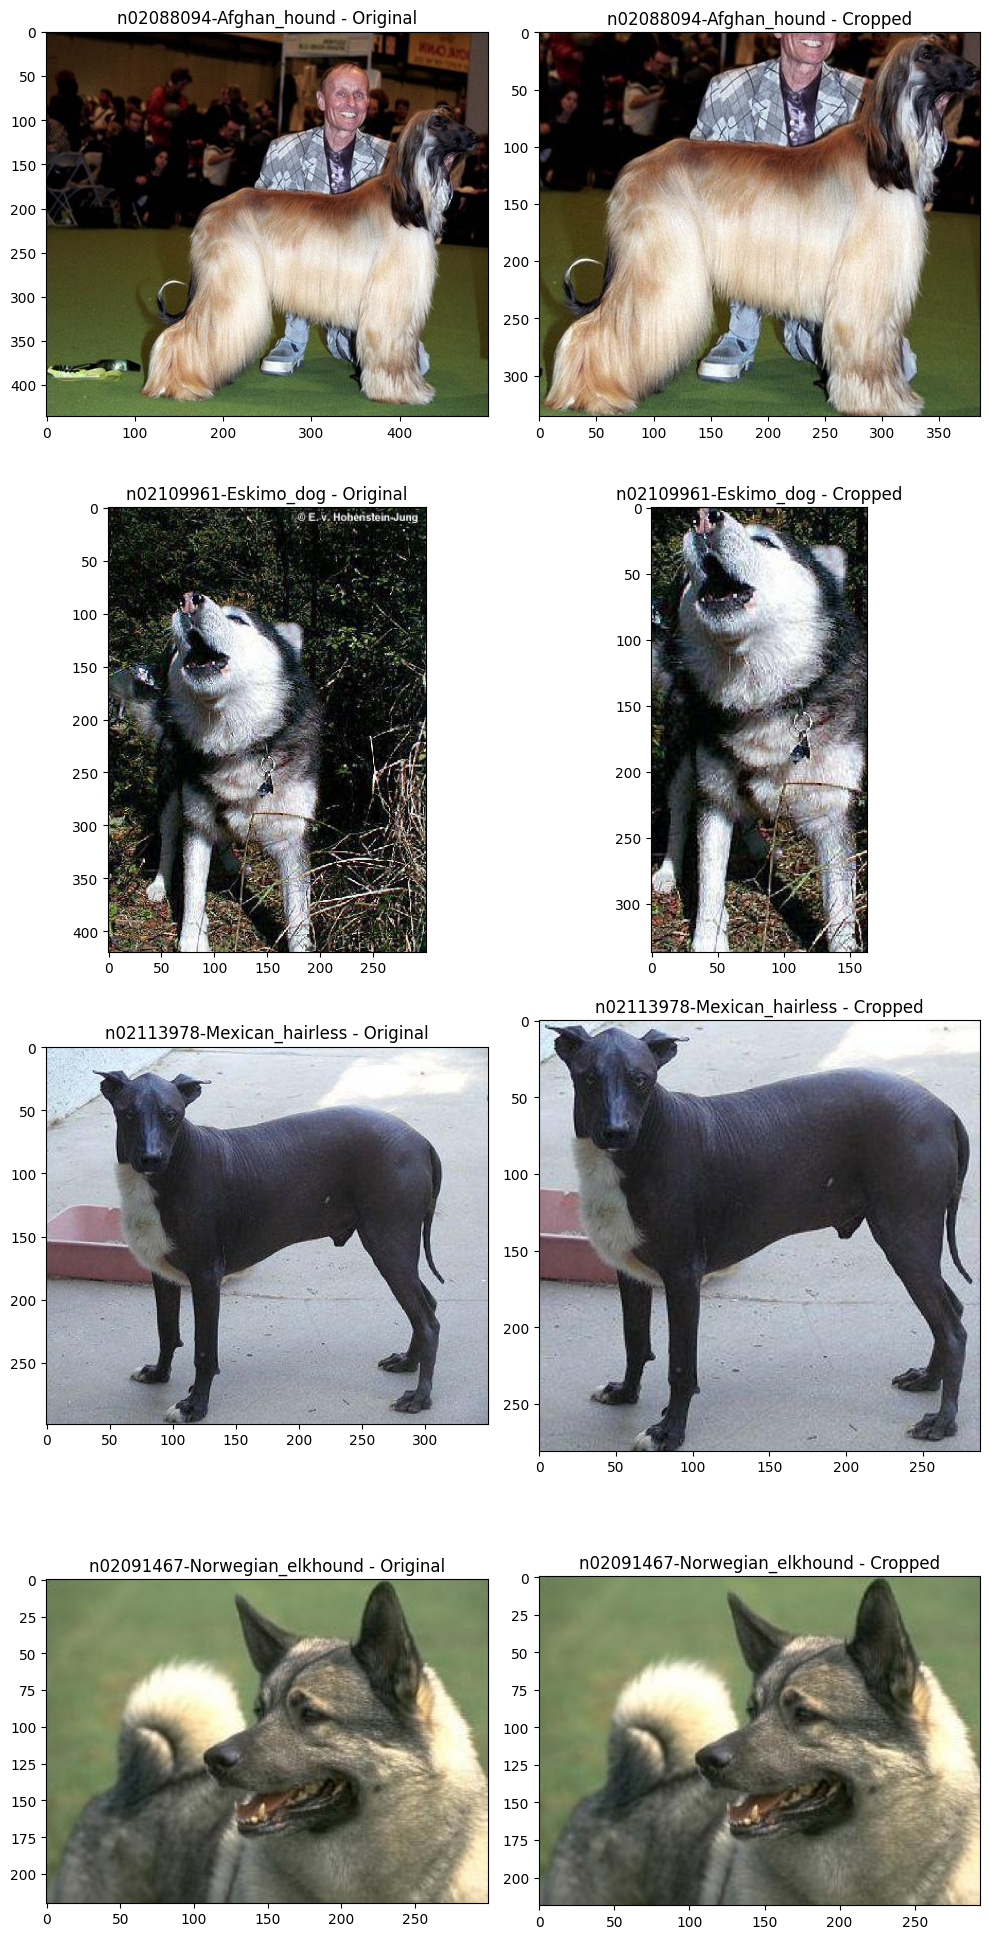

In [33]:
def get_bounding_boxes(annot_file):
    tree = ET.parse(annot_file)
    root = tree.getroot()
    objects = root.findall("object")
    bbox = []
    for obj in objects:
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox


def process_image(image_path, annot_path, class_output_dir):
    image = Image.open(image_path)

    bboxes = get_bounding_boxes(annot_path)

    for idx, bbox in enumerate(bboxes):
        cropped_img = image.crop(bbox)
        resized_img = cropped_img.resize((128, 128), Image.Resampling.LANCZOS)

        image_name = os.path.basename(image_path).replace(".jpg", f"_{idx}.jpg")
        save_path = os.path.join(class_output_dir, image_name)
        resized_img.convert("RGB").save(save_path)

    return image, cropped_img


original_imgs = {}
cropped_imgs = {}

for dog_class in dog_classes:
    class_image_dir = os.path.join(base_image_dir, dog_class)
    class_annot_dir = os.path.join(base_annot_dir, dog_class)
    class_output_dir = os.path.join(output_dir, dog_class)

    Path(class_output_dir).mkdir(parents=True, exist_ok=True)

    for img_file in os.listdir(class_image_dir):
        if img_file.endswith(".jpg"):
            image_path = os.path.join(class_image_dir, img_file)
            annot_file = os.path.join(class_annot_dir, img_file.replace(".jpg", ""))

            if os.path.exists(annot_file):
                original_img, cropped_img = process_image(
                    image_path, annot_file, class_output_dir
                )
                original_imgs[dog_class] = original_img
                cropped_imgs[dog_class] = cropped_img
                break
            else:
                print(f"Annotation file not found for {img_file}, skipping.")

    if dog_class not in original_imgs or dog_class not in cropped_imgs:
        print(f"No valid image found for class: {dog_class}")


if original_imgs and cropped_imgs:
    fig, axs = plt.subplots(len(dog_classes), 2, figsize=(10, 5 * len(dog_classes)))
    for idx, dog_class in enumerate(dog_classes):
        if dog_class in original_imgs and dog_class in cropped_imgs:
            axs[idx, 0].imshow(original_imgs[dog_class])
            axs[idx, 0].set_title(f"{dog_class} - Original")
            axs[idx, 1].imshow(cropped_imgs[dog_class])
            axs[idx, 1].set_title(f"{dog_class} - Cropped")
        else:
            axs[idx, 0].axis("off")
            axs[idx, 1].axis("off")
            axs[idx, 0].text(
                0.5, 0.5, f"No image for {dog_class}", ha="center", va="center"
            )
    plt.tight_layout()
    plt.show()
else:
    print("No images processed.")


## b)


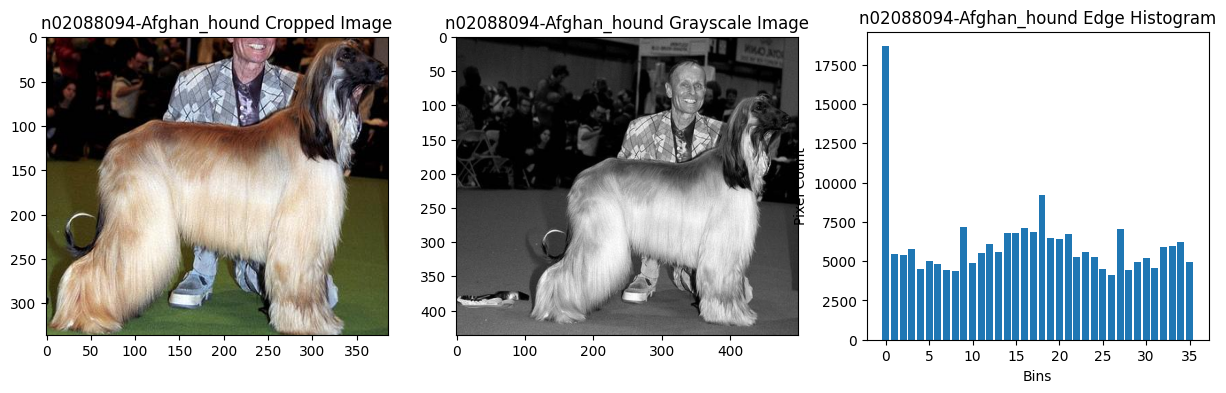

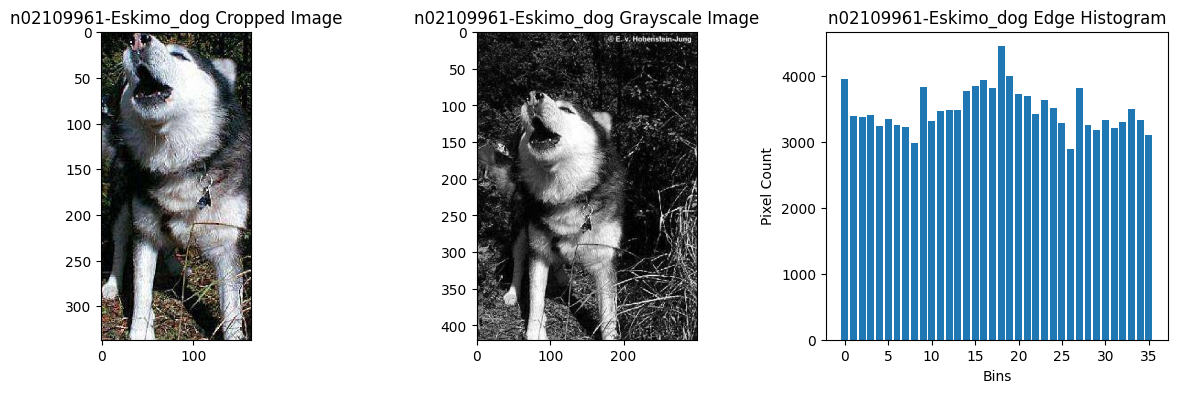

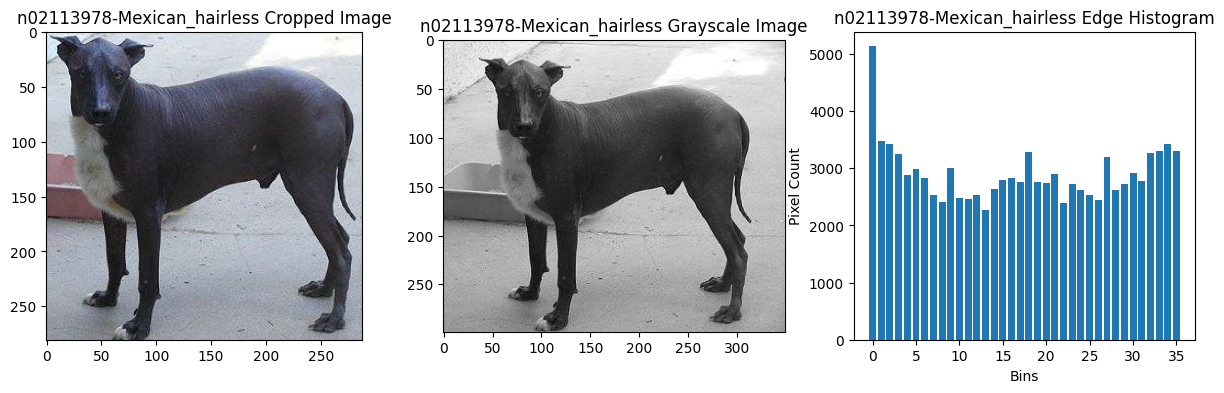

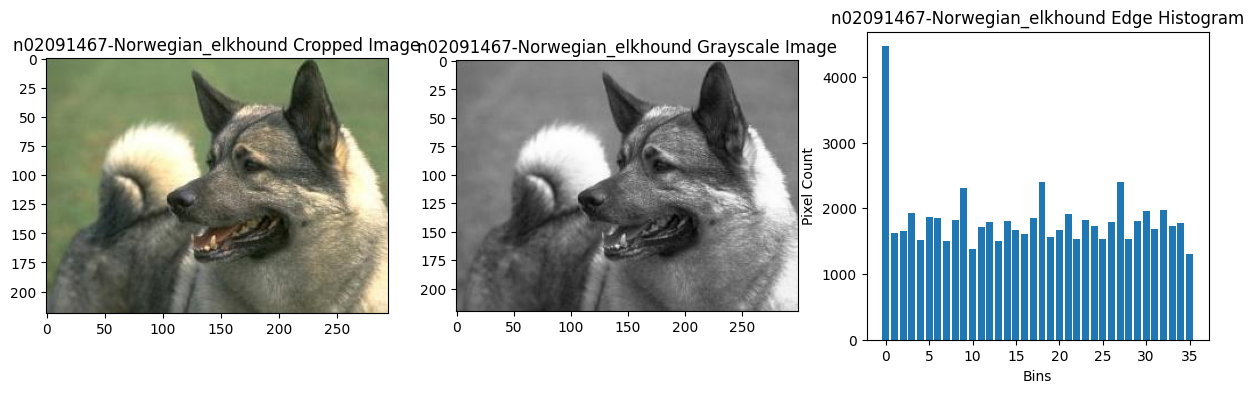

Comparing edge histograms of n02088094-Afghan_hound and n02109961-Eskimo_dog
Euclidean distance: 20212.307092462255
Manhattan distance: 92000.0
Cosine distance: 0.05251881227780886


In [34]:
def convert_to_grayscale_and_save(image_path, class_output_dir):
    image = Image.open(image_path)
    grayscale_image = image.convert("L")
    grayscale_path = os.path.join(class_output_dir, os.path.basename(image_path))
    grayscale_image.save(grayscale_path)
    return np.array(grayscale_image)


def calculate_edge_angle(grayscale_image):
    sobel_h = filters.sobel_h(grayscale_image)
    sobel_v = filters.sobel_v(grayscale_image)
    angle_sobel = np.mod(np.arctan2(sobel_v, sobel_h), np.pi)
    return angle_sobel


def compute_edge_histogram(angle_sobel):
    hist, hist_centers = exposure.histogram(angle_sobel, nbins=36)
    return hist, hist_centers


def plot_histogram(cropped_image, grayscale_image, hist, class_name):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cropped_image)
    plt.title(f"{class_name} Cropped Image")

    plt.subplot(1, 3, 2)
    plt.imshow(grayscale_image, cmap="gray")
    plt.title(f"{class_name} Grayscale Image")

    plt.subplot(1, 3, 3)
    plt.bar(range(len(hist)), hist)
    plt.xlabel("Bins")
    plt.ylabel("Pixel Count")
    plt.title(f"{class_name} Edge Histogram")
    plt.show()


def compare_histograms(hist1, hist2):
    hist1 = hist1.reshape(1, -1)
    hist2 = hist2.reshape(1, -1)
    euclidean_dist = pairwise_distances(hist1, hist2, metric="euclidean")[0][0]
    manhattan_dist = pairwise_distances(hist1, hist2, metric="manhattan")[0][0]
    cosine_dist = pairwise_distances(hist1, hist2, metric="cosine")[0][0]

    return euclidean_dist, manhattan_dist, cosine_dist


histograms = []
class_names = []

for dog_class in dog_classes:
    class_image_dir = os.path.join(base_image_dir, dog_class)
    class_output_dir = os.path.join(gray_output_dir, dog_class)
    Path(class_output_dir).mkdir(parents=True, exist_ok=True)

    img_file = os.listdir(class_image_dir)[0]
    image_path = os.path.join(class_image_dir, img_file)

    cropped_image = cropped_imgs[dog_class]
    grayscale_image = convert_to_grayscale_and_save(image_path, class_output_dir)

    angle_sobel = calculate_edge_angle(grayscale_image)

    hist, hist_centers = compute_edge_histogram(angle_sobel)

    histograms.append(hist)
    class_names.append(dog_class)

    plot_histogram(cropped_image, grayscale_image, hist, dog_class)


hist1, hist2 = histograms[0], histograms[1]
class1, class2 = class_names[0], class_names[1]

print(f"Comparing edge histograms of {class1} and {class2}")


euclidean_dist, manhattan_dist, cosine_dist = compare_histograms(hist1, hist2)


print(f"Euclidean distance: {euclidean_dist}")
print(f"Manhattan distance: {manhattan_dist}")
print(f"Cosine distance: {cosine_dist}")


## c)


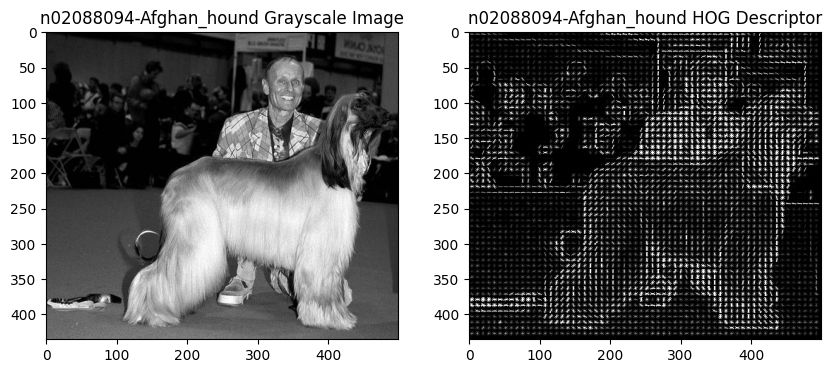

In [35]:
def compute_and_visualize_hog(grayscale_image, class_name):
    hog_features, hog_image = hog(
        grayscale_image,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        block_norm="L2-Hys",
    )

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(grayscale_image, cmap="gray")
    plt.title(f"{class_name} Grayscale Image")

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image_rescaled, cmap="gray")
    plt.title(f"{class_name} HOG Descriptor")
    plt.show()


chosen_class = "n02088094-Afghan_hound"
class_image_dir = os.path.join(gray_output_dir, chosen_class)

img_file = os.listdir(class_image_dir)[0]
grayscale_image_path = os.path.join(class_image_dir, img_file)


grayscale_image = io.imread(grayscale_image_path)


compute_and_visualize_hog(grayscale_image, chosen_class)


## d)


In [36]:
all_histograms = []
all_labels = []


for dog_class in dog_classes:
    class_image_dir = os.path.join(base_image_dir, dog_class)
    class_histogram_dir = os.path.join(edge_histograms_dir, dog_class)
    os.makedirs(class_histogram_dir, exist_ok=True)

    for img_file in os.listdir(class_image_dir):
        if img_file.endswith(".jpg"):
            image_path = os.path.join(class_image_dir, img_file)

            grayscale_image = np.array(Image.open(image_path).convert("L"))

            angle_sobel = calculate_edge_angle(grayscale_image)

            hist, _ = compute_edge_histogram(angle_sobel)

            histogram_file = os.path.splitext(img_file)[0] + "_edge_histogram.npy"
            histogram_path = os.path.join(class_histogram_dir, histogram_file)
            np.save(histogram_path, hist)

            all_histograms.append(hist)
            all_labels.append(dog_class)


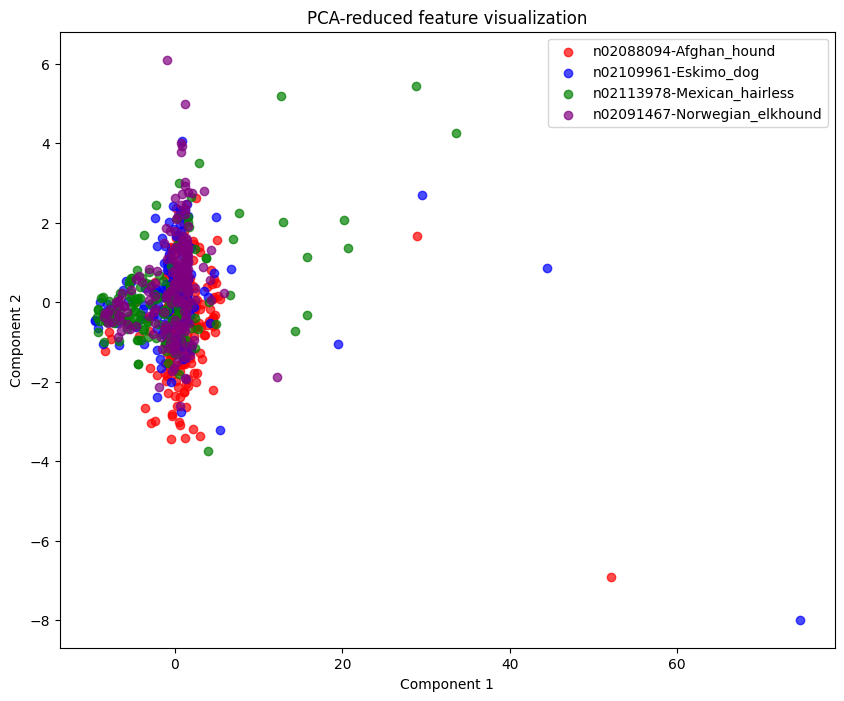

In [37]:
X = np.array(all_histograms)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
colors = ["red", "blue", "green", "purple"]
for i, dog_class in enumerate(dog_classes):
    mask = np.array(all_labels) == dog_class
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors[i], label=dog_class, alpha=0.7)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA-reduced feature visualization")
plt.legend()
plt.show()

Based on the 2D plot showing the 4 different classes, only 1 class (the green
points representing the "Mexican_hairless" class) appears to be visually
separable and non-overlapping with the other 3 classes. The data points for the
other 3 classes (red, blue, and orange) have significant overlap with each other
in the 2D feature space.


# 3.)


In [38]:
with open("train.json", "r") as f:
    data = [json.loads(line) for line in f]


df = pd.DataFrame(data)


In [39]:
selected_classes = ["anger", "joy", "love", "sadness"]
df["class"] = df[selected_classes].idxmax(axis=1)
df_filtered = df[df[selected_classes].sum(axis=1) == 1]


texts = df_filtered["Tweet"].values
labels = df_filtered["class"].values


count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()


count_features = count_vectorizer.fit_transform(texts)
tfidf_features = tfidf_vectorizer.fit_transform(texts)


count_dim = count_features.shape[1]
tfidf_dim = tfidf_features.shape[1]

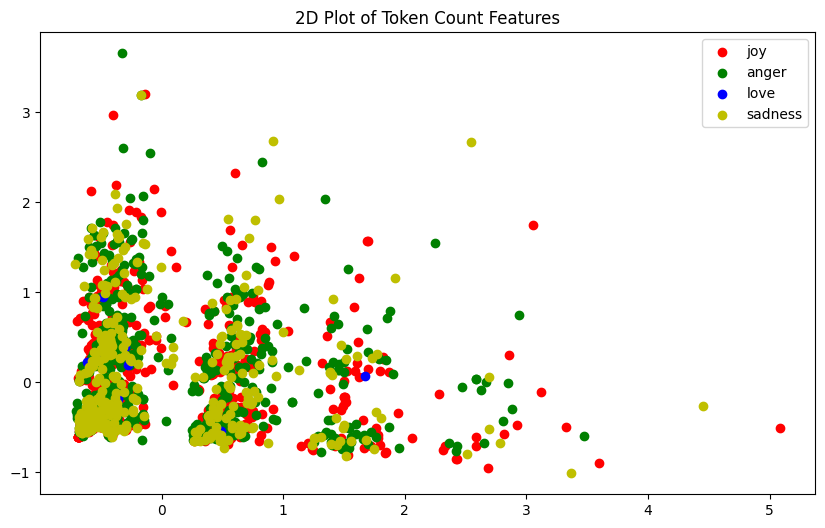

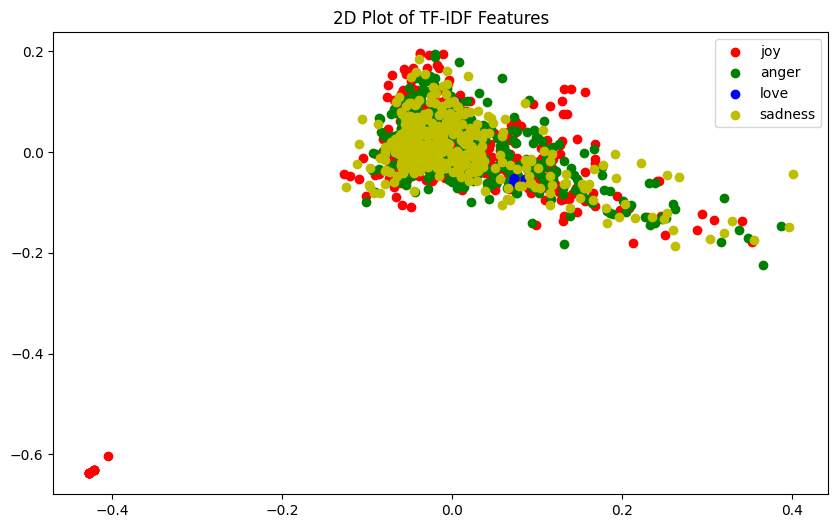

Dimensionality of token count features: 6528
Dimensionality of TF-IDF features: 6528


In [40]:
pca = PCA(n_components=2)
count_reduced = pca.fit_transform(count_features.toarray())
tfidf_reduced = pca.fit_transform(tfidf_features.toarray())


def plot_reduced_features(reduced_features, labels, title):
    plt.figure(figsize=(10, 6))
    unique_labels = list(set(labels))
    colors = ["r", "g", "b", "y"]
    for i, label in enumerate(unique_labels):
        indices = [j for j, label_j in enumerate(labels) if label_j == label]
        plt.scatter(
            reduced_features[indices, 0],
            reduced_features[indices, 1],
            c=colors[i],
            label=label,
        )
    plt.title(title)
    plt.legend()
    plt.show()


plot_reduced_features(count_reduced, labels, "2D Plot of Token Count Features")


plot_reduced_features(tfidf_reduced, labels, "2D Plot of TF-IDF Features")


print(f"Dimensionality of token count features: {count_dim}")
print(f"Dimensionality of TF-IDF features: {tfidf_dim}")

For both token count and TF-IDF features, no classes are clearly separable as
there is significant overlap among the classes in the 2D PCA projection.
